In [1]:
# %%
"""
# Customer Support RAG - Exploratory Data Analysis
## BANKING77 Dataset Analysis

This notebook performs comprehensive EDA on the BANKING77 customer support dataset.
"""

# %% [markdown]
# ## 1. Setup and Imports

# %%
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from collections import Counter
import re
import warnings
from typing import List, Dict
import json
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("✅ All imports successful!")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")

✅ All imports successful!
Pandas: 2.3.3
NumPy: 1.26.4


In [2]:
# ## 2. Load Dataset

# %%
print("📥 Loading BANKING77 dataset from Hugging Face...")
print("This may take a minute on first run...\n")

# Load dataset
banking = load_dataset("banking77")

# Convert to pandas DataFrames
train_df = pd.DataFrame(banking['train'])
test_df = pd.DataFrame(banking['test'])

# Get label names
label_names = banking['train'].features['label'].names

print("✅ Dataset loaded successfully!")
print(f"\n📊 Dataset Statistics:")
print(f"  Training samples: {len(train_df):,}")
print(f"  Test samples: {len(test_df):,}")
print(f"  Total samples: {len(train_df) + len(test_df):,}")
print(f"  Number of categories: {len(label_names)}")

📥 Loading BANKING77 dataset from Hugging Face...
This may take a minute on first run...

✅ Dataset loaded successfully!

📊 Dataset Statistics:
  Training samples: 10,003
  Test samples: 3,080
  Total samples: 13,083
  Number of categories: 77


In [3]:
# ## 3. Initial Data Inspection

# %%
print("="*70)
print("DATASET STRUCTURE")
print("="*70)

print("\n📋 First 10 rows:")
display(train_df.head(10))

print("\n📋 Dataset Info:")
print(train_df.info())

print("\n📋 Data Types:")
print(train_df.dtypes)

print("\n📋 Sample Questions:")
for i, text in enumerate(train_df['text'].sample(5).values, 1):
    print(f"{i}. {text}")

# %%
print("\n" + "="*70)
print("DATA QUALITY CHECKS")
print("="*70)

# Check for missing values
print("\n🔍 Missing Values:")
missing = train_df.isnull().sum()
if missing.sum() == 0:
    print("  ✅ No missing values found!")
else:
    print(missing)

# Check for duplicates
duplicates = train_df.duplicated(subset=['text']).sum()
print(f"\n🔍 Duplicate Questions: {duplicates} ({duplicates/len(train_df)*100:.2f}%)")

if duplicates > 0:
    print("\n  Sample duplicates:")
    dup_texts = train_df[train_df.duplicated(subset=['text'], keep=False)].sort_values('text')
    display(dup_texts.head(10))

# Check for empty strings
empty = (train_df['text'].str.strip() == '').sum()
print(f"\n🔍 Empty Strings: {empty}")

DATASET STRUCTURE

📋 First 10 rows:


,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived after 2 weeks?,11
2,I have been waiting over a week. Is the card still coming?,11
3,Can I track my card while it is in the process of delivery?,11
4,"How do I know if I will get my card, or if it is lost?",11
5,When did you send me my new card?,11
6,Do you have info about the card on delivery?,11
7,What do I do if I still have not received my new card?,11
8,Does the package with my card have tracking?,11
9,I ordered my card but it still isn't here,11



📋 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10003 entries, 0 to 10002
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10003 non-null  object
 1   label   10003 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB
None

📋 Data Types:
text     object
label     int64
dtype: object

📋 Sample Questions:
1. How do I terminate my account.
2. Where can I find the verification code for the top up card?
3. I'd like to know what you guys look at to decide an exchange rate
4. Explain the card PIN to me.
5. Is there a problem with your system being down or something? I have already tried 5 times to issue a standard transfer but I'm getting nowhere.

DATA QUALITY CHECKS

🔍 Missing Values:
  ✅ No missing values found!

🔍 Duplicate Questions: 0 (0.00%)

🔍 Empty Strings: 0


TEXT LENGTH STATISTICS

📏 Character Length:
  Mean: 59.5
  Median: 47.0
  Std: 40.9
  Min: 13
  Max: 433

📏 Word Count:
  Mean: 11.9
  Median: 10.0
  Std: 7.9
  Min: 2
  Max: 79

📊 Percentiles (Word Count):
  10th percentile: 6 words
  25th percentile: 7 words
  50th percentile: 10 words
  75th percentile: 13 words
  90th percentile: 22 words
  95th percentile: 29 words
  99th percentile: 43 words


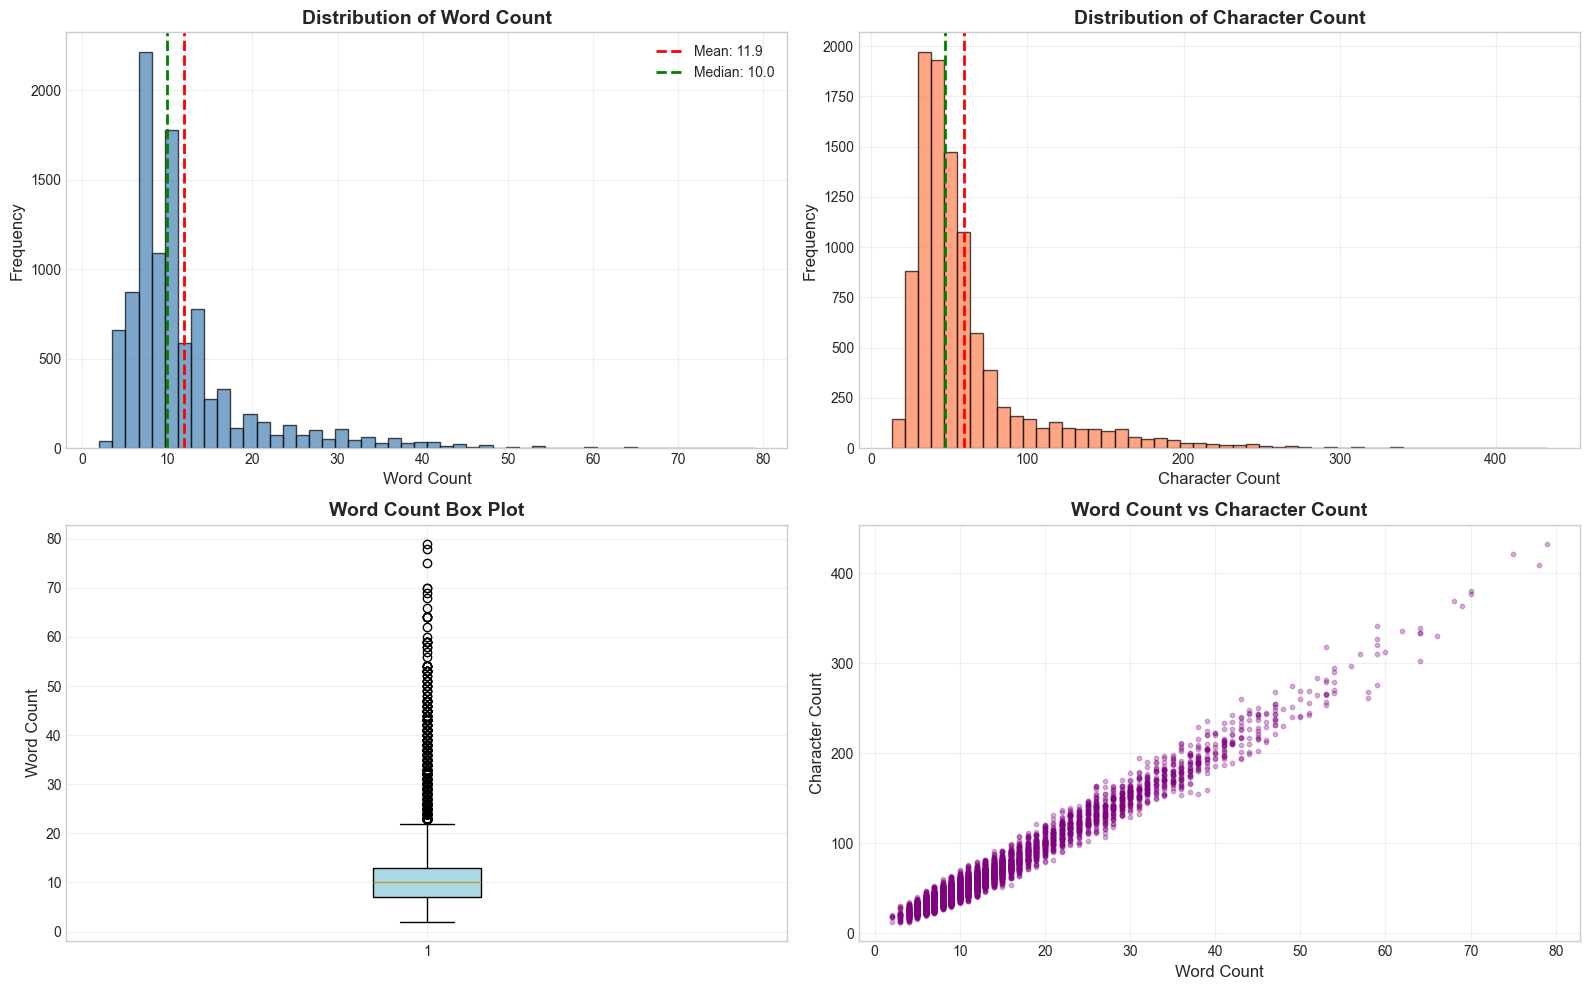


📝 EXAMPLES - Shortest Questions:
----------------------------------------------------------------------
[2 words] Cancel Transaction
[2 words] passcode retrieval
[2 words] Lost password
[2 words] pending transaction?
[2 words] Transfer declined.

📝 EXAMPLES - Longest Questions:
----------------------------------------------------------------------
[79 words] Hearing back from us regarding your important verification results may take 10 minutes to one hour time.  If verification results do fail, double-check to make sure all of your images are clear --  make sure your photos have no glare or blurring. Note: These photos need to be readable as well.  You also need to be 18 years of age or older.  You must be a resident of Switzerland or the European Economic Area to open a new account.
[78 words] Hi! I'm a university student studying abroad and I noticed that when I was trying to cross-reference my budget for this month that there were extra fees I was not expecting. Why is that? I've h

In [4]:
# ## 4. Text Length Analysis

# %%
# Calculate text statistics
train_df['text_length'] = train_df['text'].str.len()
train_df['word_count'] = train_df['text'].str.split().str.len()
train_df['char_count'] = train_df['text'].apply(lambda x: len(x))

print("="*70)
print("TEXT LENGTH STATISTICS")
print("="*70)

print("\n📏 Character Length:")
print(f"  Mean: {train_df['text_length'].mean():.1f}")
print(f"  Median: {train_df['text_length'].median():.1f}")
print(f"  Std: {train_df['text_length'].std():.1f}")
print(f"  Min: {train_df['text_length'].min()}")
print(f"  Max: {train_df['text_length'].max()}")

print("\n📏 Word Count:")
print(f"  Mean: {train_df['word_count'].mean():.1f}")
print(f"  Median: {train_df['word_count'].median():.1f}")
print(f"  Std: {train_df['word_count'].std():.1f}")
print(f"  Min: {train_df['word_count'].min()}")
print(f"  Max: {train_df['word_count'].max()}")

print("\n📊 Percentiles (Word Count):")
percentiles = [10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    value = np.percentile(train_df['word_count'], p)
    print(f"  {p}th percentile: {value:.0f} words")

# %%
# Visualize text length distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Word count histogram
axes[0, 0].hist(train_df['word_count'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(train_df['word_count'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {train_df["word_count"].mean():.1f}')
axes[0, 0].axvline(train_df['word_count'].median(), color='green', linestyle='--', 
                   linewidth=2, label=f'Median: {train_df["word_count"].median():.1f}')
axes[0, 0].set_xlabel('Word Count', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Distribution of Word Count', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Character length histogram
axes[0, 1].hist(train_df['text_length'], bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].axvline(train_df['text_length'].mean(), color='red', linestyle='--', linewidth=2)
axes[0, 1].axvline(train_df['text_length'].median(), color='green', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Character Count', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Distribution of Character Count', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Box plot
axes[1, 0].boxplot(train_df['word_count'], vert=True, patch_artist=True,
                   boxprops=dict(facecolor='lightblue'))
axes[1, 0].set_ylabel('Word Count', fontsize=12)
axes[1, 0].set_title('Word Count Box Plot', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Scatter: word count vs character count
axes[1, 1].scatter(train_df['word_count'], train_df['text_length'], 
                   alpha=0.3, s=10, color='purple')
axes[1, 1].set_xlabel('Word Count', fontsize=12)
axes[1, 1].set_ylabel('Character Count', fontsize=12)
axes[1, 1].set_title('Word Count vs Character Count', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/text_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
print("\n📝 EXAMPLES - Shortest Questions:")
print("-" * 70)
shortest = train_df.nsmallest(5, 'word_count')[['text', 'word_count', 'label']]
for idx, row in shortest.iterrows():
    print(f"[{row['word_count']} words] {row['text']}")

print("\n📝 EXAMPLES - Longest Questions:")
print("-" * 70)
longest = train_df.nlargest(5, 'word_count')[['text', 'word_count', 'label']]
for idx, row in longest.iterrows():
    print(f"[{row['word_count']} words] {row['text']}")


CATEGORY DISTRIBUTION

Total unique categories: 77

📊 Top 15 Most Common Categories:
category
card_payment_fee_charged                            187
direct_debit_payment_not_recognised                 182
balance_not_updated_after_cheque_or_cash_deposit    181
wrong_amount_of_cash_received                       180
cash_withdrawal_charge                              177
transaction_charged_twice                           175
declined_cash_withdrawal                            173
transfer_fee_charged                                172
transfer_not_received_by_recipient                  171
balance_not_updated_after_bank_transfer             171
request_refund                                      169
card_payment_not_recognised                         168
card_payment_wrong_exchange_rate                    167
extra_charge_on_statement                           166
wrong_exchange_rate_for_cash_withdrawal             163

📊 Bottom 15 Least Common Categories:
category
passcode_forgotten 

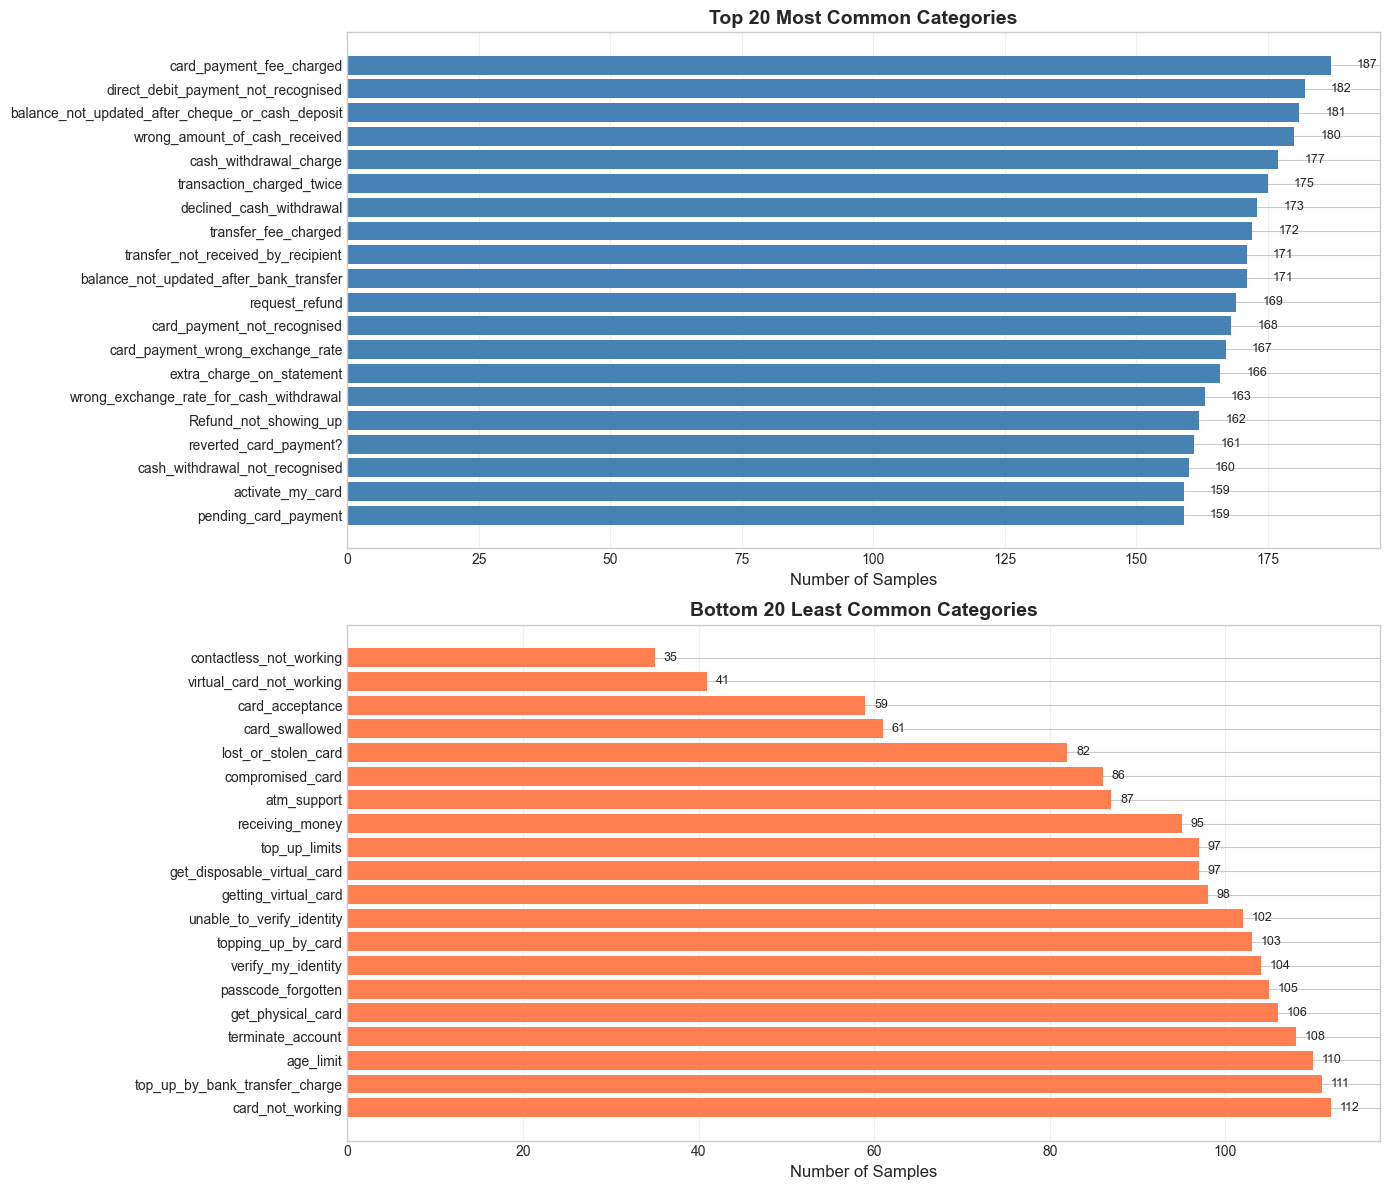


SAMPLE QUESTIONS BY CATEGORY (Top 10)

📌 CARD PAYMENT FEE CHARGED
   Total samples: 187
   1. Why was there an additional fee on the payment I just made? I don't usually have additional fees applied to my payments.
   2. I made a purchase with my card and I was charged a fee for using it
   3. I paid with my card and ended up being charged a fee.

📌 DIRECT DEBIT PAYMENT NOT RECOGNISED
   Total samples: 182
   1. There is a direct debit transaction on my statement that I think is not mine. How do I remove?
   2. I know this very late, but I just went through my statements from the last couple months and there's one quite large-ish payment that I definitely haven't made. Is it still possible to dispute it?
   3. Can you help me figure out what is going on with a debit payment that is showing up on my account I am not sure is suppose to be there.

📌 BALANCE NOT UPDATED AFTER CHEQUE OR CASH DEPOSIT
   Total samples: 181
   1. I made a deposit and the balance hasn't been updated.
   2. Wha

In [5]:
# ## 5. Category Distribution Analysis

# %%
# Map labels to category names
train_df['category'] = train_df['label'].map(lambda x: label_names[x])
test_df['category'] = test_df['label'].map(lambda x: label_names[x])

print("="*70)
print("CATEGORY DISTRIBUTION")
print("="*70)

category_counts = train_df['category'].value_counts()

print(f"\nTotal unique categories: {len(category_counts)}")
print(f"\n📊 Top 15 Most Common Categories:")
print(category_counts.head(15).to_string())

print(f"\n📊 Bottom 15 Least Common Categories:")
print(category_counts.tail(15).to_string())

print("\n📊 Category Statistics:")
print(f"  Most common: '{category_counts.index[0]}' with {category_counts.iloc[0]} samples")
print(f"  Least common: '{category_counts.index[-1]}' with {category_counts.iloc[-1]} samples")
print(f"  Imbalance ratio: {category_counts.iloc[0] / category_counts.iloc[-1]:.2f}x")
print(f"  Average samples per category: {category_counts.mean():.1f}")
print(f"  Median samples per category: {category_counts.median():.1f}")

# %%
# Visualize category distribution
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Top 20 categories
top_20 = category_counts.head(20)
axes[0].barh(range(len(top_20)), top_20.values, color='steelblue')
axes[0].set_yticks(range(len(top_20)))
axes[0].set_yticklabels(top_20.index)
axes[0].set_xlabel('Number of Samples', fontsize=12)
axes[0].set_title('Top 20 Most Common Categories', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(top_20.values):
    axes[0].text(v + 5, i, str(v), va='center', fontsize=9)

# Bottom 20 categories
bottom_20 = category_counts.tail(20).sort_values()
axes[1].barh(range(len(bottom_20)), bottom_20.values, color='coral')
axes[1].set_yticks(range(len(bottom_20)))
axes[1].set_yticklabels(bottom_20.index)
axes[1].set_xlabel('Number of Samples', fontsize=12)
axes[1].set_title('Bottom 20 Least Common Categories', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(bottom_20.values):
    axes[1].text(v + 1, i, str(v), va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../data/category_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Sample questions from each top category
print("\n" + "="*70)
print("SAMPLE QUESTIONS BY CATEGORY (Top 10)")
print("="*70)

for category in category_counts.head(10).index:
    print(f"\n📌 {category.upper().replace('_', ' ')}")
    print(f"   Total samples: {category_counts[category]}")
    samples = train_df[train_df['category'] == category]['text'].sample(min(3, category_counts[category]))
    for i, text in enumerate(samples, 1):
        print(f"   {i}. {text}")

VOCABULARY ANALYSIS

⏳ Tokenizing all questions...

📊 Vocabulary Statistics:
  Total words (with repetition): 122,299
  Unique words: 2,312
  Vocabulary richness: 0.0189
  Words appearing only once: 852
  Average word frequency: 52.90

📊 Top 30 Most Common Words:
----------------------------------------------------------------------
 1. i                    :  8807 occurrences
 2. my                   :  5684 occurrences
 3. to                   :  4039 occurrences
 4. a                    :  3565 occurrences
 5. the                  :  3498 occurrences
 6. card                 :  2682 occurrences
 7. is                   :  2377 occurrences
 8. can                  :  2070 occurrences
 9. it                   :  2062 occurrences
10. do                   :  1849 occurrences
11. t                    :  1582 occurrences
12. for                  :  1581 occurrences
13. what                 :  1542 occurrences
14. how                  :  1524 occurrences
15. why                  :  1368 oc

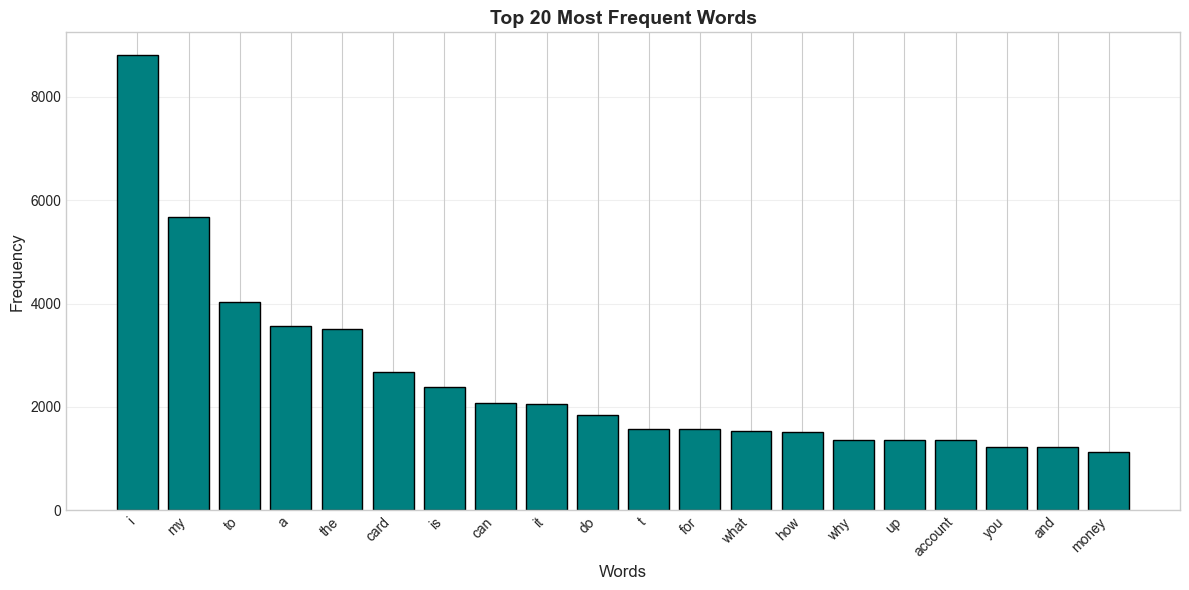


📊 Frequency of Customer Support Keywords:
----------------------------------------------------------------------
  card            :  2682 occurrences
  account         :  1352 occurrences
  transfer        :  1084 occurrences
  top             :  1045 occurrences
  payment         :   751 occurrences
  cash            :   691 occurrences
  exchange        :   549 occurrences
  atm             :   482 occurrences
  fee             :   458 occurrences
  pending         :   424 occurrences
  transaction     :   354 occurrences
  charge          :   310 occurrences
  declined        :   294 occurrences
  refund          :   288 occurrences
  virtual         :   227 occurrences
  disposable      :   215 occurrences
  verify          :   158 occurrences
  balance         :   122 occurrences
  cancelled       :    76 occurrences
  passcode        :    64 occurrences
  failed          :    62 occurrences
  contactless     :    28 occurrences


In [6]:
# ## 6. Vocabulary Analysis

# %%
print("="*70)
print("VOCABULARY ANALYSIS")
print("="*70)

# Tokenization function
def simple_tokenize(text):
    """Simple word tokenization"""
    return re.findall(r'\b[a-z]+\b', text.lower())

# Extract all words
print("\n⏳ Tokenizing all questions...")
all_words = []
for text in train_df['text']:
    all_words.extend(simple_tokenize(text))

word_freq = Counter(all_words)

print(f"\n📊 Vocabulary Statistics:")
print(f"  Total words (with repetition): {len(all_words):,}")
print(f"  Unique words: {len(word_freq):,}")
print(f"  Vocabulary richness: {len(word_freq) / len(all_words):.4f}")

# Words appearing only once (hapax legomena)
hapax = [word for word, count in word_freq.items() if count == 1]
print(f"  Words appearing only once: {len(hapax):,}")

# Average word frequency
print(f"  Average word frequency: {np.mean(list(word_freq.values())):.2f}")

# %%
print("\n📊 Top 30 Most Common Words:")
print("-" * 70)
for i, (word, count) in enumerate(word_freq.most_common(30), 1):
    print(f"{i:2d}. {word:20s} : {count:5d} occurrences")

# %%
# Visualize word frequency
top_words = dict(word_freq.most_common(20))

plt.figure(figsize=(12, 6))
plt.bar(top_words.keys(), top_words.values(), color='teal', edgecolor='black')
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Top 20 Most Frequent Words', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../data/word_frequency.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Domain-specific keywords
print("\n📊 Frequency of Customer Support Keywords:")
print("-" * 70)

support_keywords = [
    'card', 'payment', 'transfer', 'account', 'balance', 'charge',
    'refund', 'transaction', 'fee', 'verify', 'exchange', 'cash',
    'top', 'atm', 'virtual', 'contactless', 'disposable', 'passcode',
    'failed', 'pending', 'declined', 'cancelled'
]

keyword_freq = {kw: word_freq.get(kw, 0) for kw in support_keywords}
keyword_freq = dict(sorted(keyword_freq.items(), key=lambda x: x[1], reverse=True))

for keyword, count in keyword_freq.items():
    if count > 0:
        print(f"  {keyword:15s} : {count:5d} occurrences")



QUESTION TYPE ANALYSIS

📊 Question Type Distribution:
question_type
statement             3233
other_question        2026
how                   1053
what                   915
why                    874
yes_no                 794
permission/ability     645
where                  239
when                   152
which                   51
who                     21


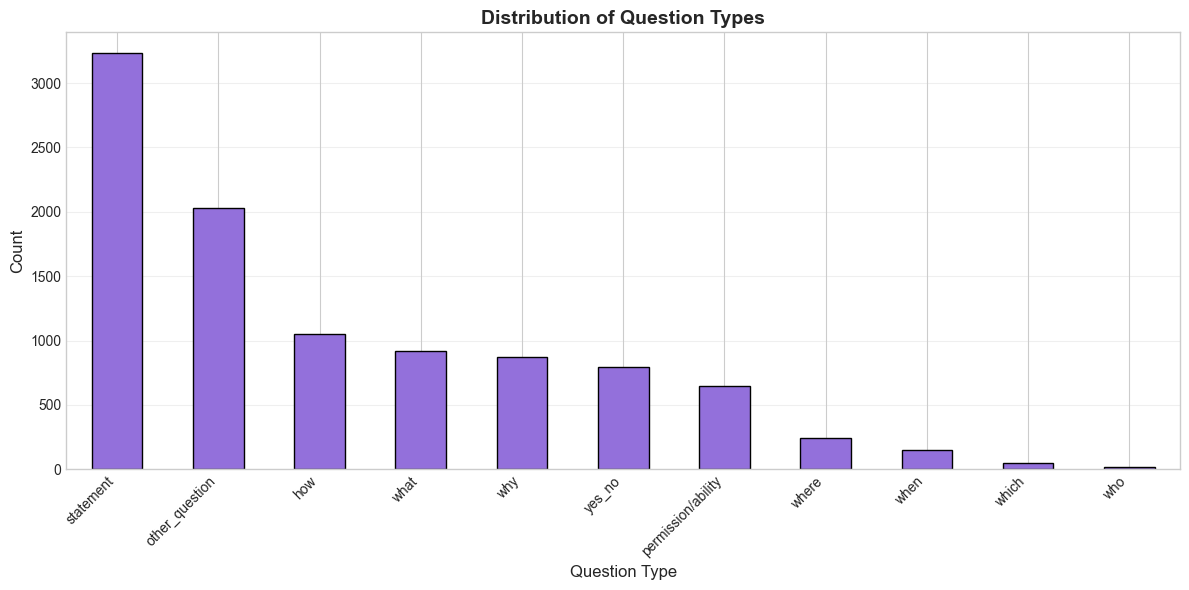


📝 EXAMPLES BY QUESTION TYPE:

STATEMENT:
  1. I dont have a pin
  2. Give me back my money, I'm not paying the sellers. It has been a long time ago that I made an order and it just isn't coming.
  3. The exchange rate on my payment doesn't look right

OTHER_QUESTION:
  1. i need help. I updated my balance with a check yesterday and Im not seeing it. Can you look at my account to see what went wrong?
  2. I think someone might have a copy of my card because a 500 dollar withdrawal was made, and it wasn't me. Can you please help?
  3. A transaction I did to my friend hasn't arrived yet, why?

HOW:
  1. How do I know which payments I make will have additional fees? Where can I find this information online?
  2. How can I reset my darned PIN number?
  3. How can I go about transferring money to my account?

WHAT:
  1. What countries can I use the card in?
  2. What are the disposable cards used for?
  3. What documents do I need to get together to verify my identity?

WHY:
  1. Why is the

In [7]:
# ## 7. Question Type Analysis

# %%
def classify_question_type(text):
    """Classify question type based on starting words"""
    text_lower = text.lower().strip()
    
    # Check for question words
    if text_lower.startswith(('how', 'how do', 'how can', 'how to', 'how much')):
        return 'how'
    elif text_lower.startswith(('what', 'what is', 'what are', 'what\'s')):
        return 'what'
    elif text_lower.startswith(('why', 'why is', 'why are', 'why does', 'why did')):
        return 'why'
    elif text_lower.startswith(('when', 'when is', 'when will', 'when can', 'when do')):
        return 'when'
    elif text_lower.startswith(('where', 'where is', 'where can', 'where do')):
        return 'where'
    elif text_lower.startswith(('who', 'who is', 'who are')):
        return 'who'
    elif text_lower.startswith(('which', 'which is', 'which are')):
        return 'which'
    elif text_lower.startswith(('can i', 'could i', 'may i', 'can you', 'could you')):
        return 'permission/ability'
    elif text_lower.startswith(('is', 'are', 'was', 'were', 'do', 'does', 'did', 'has', 'have')):
        return 'yes_no'
    elif '?' in text:
        return 'other_question'
    else:
        return 'statement'

train_df['question_type'] = train_df['text'].apply(classify_question_type)

print("="*70)
print("QUESTION TYPE ANALYSIS")
print("="*70)

question_type_dist = train_df['question_type'].value_counts()
print("\n📊 Question Type Distribution:")
print(question_type_dist.to_string())

# %%
# Visualize question types
plt.figure(figsize=(12, 6))
question_type_dist.plot(kind='bar', color='mediumpurple', edgecolor='black')
plt.xlabel('Question Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Question Types', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../data/question_types.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
print("\n📝 EXAMPLES BY QUESTION TYPE:")
print("="*70)

for qtype in question_type_dist.index[:7]:
    print(f"\n{qtype.upper()}:")
    examples = train_df[train_df['question_type'] == qtype]['text'].sample(min(3, len(train_df[train_df['question_type'] == qtype])))
    for i, text in enumerate(examples, 1):
        print(f"  {i}. {text}")

# %% [markdown]
# ## 8. Complexity Analysis

# %%
print("="*70)
print("QUERY COMPLEXITY ANALYSIS")
print("="*70)

# Define complexity indicators
train_df['has_and'] = train_df['text'].str.lower().str.contains(' and ', regex=False)
train_df['has_or'] = train_df['text'].str.lower().str.contains(' or ', regex=False)
train_df['has_but'] = train_df['text'].str.lower().str.contains(' but ', regex=False)
train_df['has_negation'] = train_df['text'].str.lower().str.contains(
    r'\b(not|no|never|cannot|can\'t|won\'t|don\'t|didn\'t|hasn\'t|haven\'t)\b', 
    regex=True
)
train_df['has_multiple_sentences'] = train_df['text'].str.count(r'[.!?]') > 1
train_df['has_question_mark'] = train_df['text'].str.contains('\?', regex=True)

# Calculate percentages
print("\n📊 Complexity Indicators:")
print(f"  Queries with 'and': {train_df['has_and'].sum():,} ({train_df['has_and'].mean()*100:.1f}%)")
print(f"  Queries with 'or': {train_df['has_or'].sum():,} ({train_df['has_or'].mean()*100:.1f}%)")
print(f"  Queries with 'but': {train_df['has_but'].sum():,} ({train_df['has_but'].mean()*100:.1f}%)")
print(f"  Queries with negation: {train_df['has_negation'].sum():,} ({train_df['has_negation'].mean()*100:.1f}%)")
print(f"  Multiple sentences: {train_df['has_multiple_sentences'].sum():,} ({train_df['has_multiple_sentences'].mean()*100:.1f}%)")
print(f"  Contains '?': {train_df['has_question_mark'].sum():,} ({train_df['has_question_mark'].mean()*100:.1f}%)")

# Define "complex" queries
train_df['is_complex'] = (
    (train_df['word_count'] > 15) | 
    (train_df['has_and'] & train_df['has_or']) |
    (train_df['has_negation'] & (train_df['has_and'] | train_df['has_or']))
)

complex_pct = train_df['is_complex'].mean() * 100
print(f"\n📊 Overall Complex Queries: {train_df['is_complex'].sum():,} ({complex_pct:.1f}%)")

# %%
print("\n📝 EXAMPLES - Simple Queries:")
print("-" * 70)
simple_queries = train_df[
    (~train_df['has_and']) & 
    (~train_df['has_or']) & 
    (train_df['word_count'] < 10)
]['text'].sample(5)

for i, text in enumerate(simple_queries, 1):
    print(f"{i}. {text}")

print("\n📝 EXAMPLES - Complex Queries:")
print("-" * 70)
complex_queries = train_df[train_df['is_complex']]['text'].sample(min(5, train_df['is_complex'].sum()))

for i, text in enumerate(complex_queries, 1):
    print(f"{i}. {text}")

print("\n📝 EXAMPLES - Queries with Negation:")
print("-" * 70)
negation_queries = train_df[train_df['has_negation']]['text'].sample(min(5, train_df['has_negation'].sum()))

for i, text in enumerate(negation_queries, 1):
    print(f"{i}. {text}")

TRAIN/TEST SPLIT ANALYSIS

📊 Dataset Split:
  Training set: 10,003 samples (76.5%)
  Test set: 3,080 samples (23.5%)

📊 Word Count Comparison:
  Train - Mean: 11.95, Median: 10
  Test  - Mean: 10.95, Median: 9

📊 Category Distribution Similarity:
  Categories in train: 77
  Categories in test: 77
  ✅ All test categories exist in training set


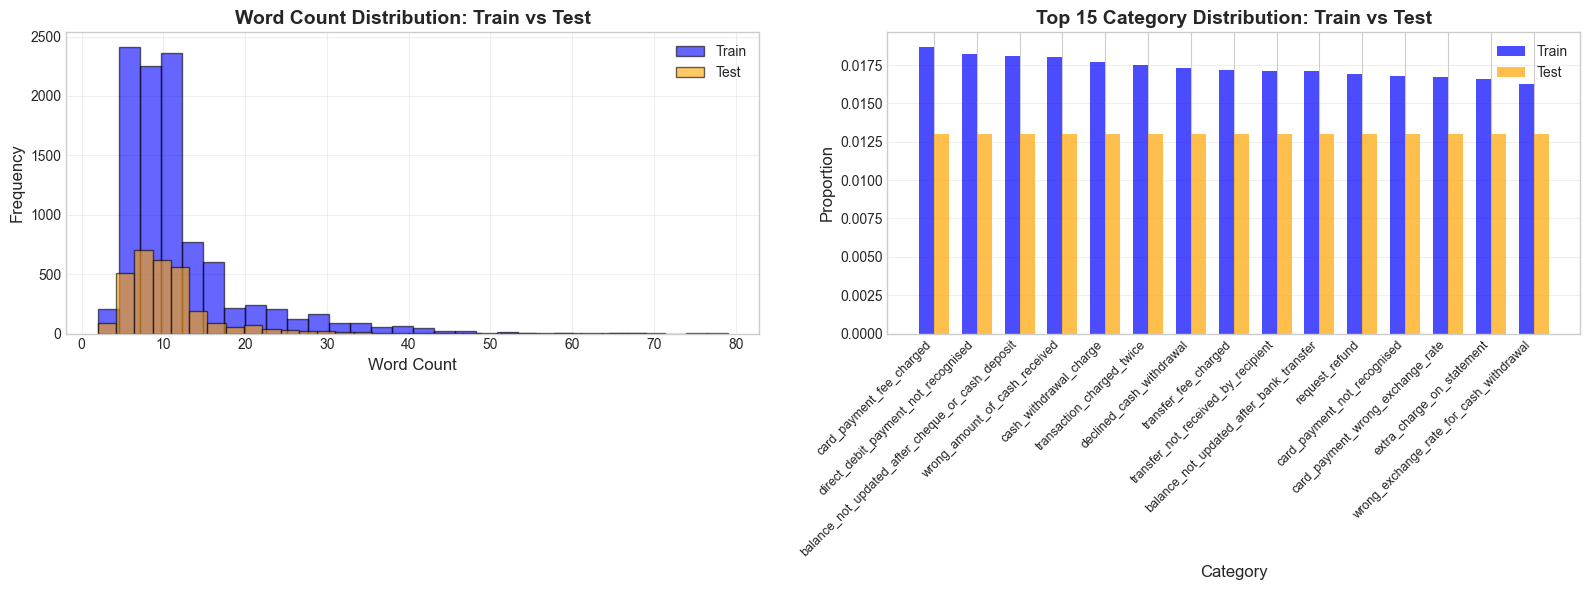

In [8]:
# ## 9. Train/Test Split Analysis

# %%
print("="*70)
print("TRAIN/TEST SPLIT ANALYSIS")
print("="*70)

# Add text features to test set
test_df['word_count'] = test_df['text'].str.split().str.len()
test_df['text_length'] = test_df['text'].str.len()

print("\n📊 Dataset Split:")
print(f"  Training set: {len(train_df):,} samples ({len(train_df)/(len(train_df)+len(test_df))*100:.1f}%)")
print(f"  Test set: {len(test_df):,} samples ({len(test_df)/(len(train_df)+len(test_df))*100:.1f}%)")

print("\n📊 Word Count Comparison:")
print(f"  Train - Mean: {train_df['word_count'].mean():.2f}, Median: {train_df['word_count'].median():.0f}")
print(f"  Test  - Mean: {test_df['word_count'].mean():.2f}, Median: {test_df['word_count'].median():.0f}")

# Category distribution comparison
train_cat_dist = train_df['category'].value_counts(normalize=True)
test_cat_dist = test_df['category'].value_counts(normalize=True)

print("\n📊 Category Distribution Similarity:")
print(f"  Categories in train: {train_df['category'].nunique()}")
print(f"  Categories in test: {test_df['category'].nunique()}")

# Check if all test categories exist in train
missing_categories = set(test_df['category']) - set(train_df['category'])
if missing_categories:
    print(f"  ⚠️ Categories in test but not in train: {missing_categories}")
else:
    print(f"  ✅ All test categories exist in training set")

# %%
# Visualize train vs test distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Word count distribution
axes[0].hist(train_df['word_count'], bins=30, alpha=0.6, label='Train', color='blue', edgecolor='black')
axes[0].hist(test_df['word_count'], bins=30, alpha=0.6, label='Test', color='orange', edgecolor='black')
axes[0].set_xlabel('Word Count', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Word Count Distribution: Train vs Test', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Category distribution (top 15)
top_15_categories = train_cat_dist.head(15).index
train_top15 = train_cat_dist[top_15_categories]
test_top15 = test_cat_dist[top_15_categories]

x = np.arange(len(top_15_categories))
width = 0.35

axes[1].bar(x - width/2, train_top15.values, width, label='Train', color='blue', alpha=0.7)
axes[1].bar(x + width/2, test_top15.values, width, label='Test', color='orange', alpha=0.7)
axes[1].set_xlabel('Category', fontsize=12)
axes[1].set_ylabel('Proportion', fontsize=12)
axes[1].set_title('Top 15 Category Distribution: Train vs Test', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(top_15_categories, rotation=45, ha='right', fontsize=9)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../data/train_test_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# ## 10. Key Insights & Recommendations

# %%
print("\n" + "="*70)
print("🎯 KEY INSIGHTS FOR RAG SYSTEM DESIGN")
print("="*70)

insights = []

# 1. Query length
avg_words = train_df['word_count'].mean()
if avg_words < 15:
    insights.append(f"✅ SHORT QUERIES (avg {avg_words:.1f} words)")
    insights.append("   → Use sentence-level embeddings (sentence-transformers)")
    insights.append("   → Chunk size: 200-300 tokens should be sufficient")
else:
    insights.append(f"⚠️ LONG QUERIES (avg {avg_words:.1f} words)")
    insights.append("   → Consider paragraph-level embeddings")
    insights.append("   → Chunk size: 500+ tokens recommended")

# 2. Vocabulary
vocab_richness = len(word_freq) / len(all_words)
if vocab_richness > 0.1:
    insights.append(f"\n✅ RICH VOCABULARY (richness: {vocab_richness:.4f})")
    insights.append("   → Domain-specific embeddings may improve performance")
    insights.append("   → Consider fine-tuning on banking/finance corpus")
else:
    insights.append(f"\n✅ FOCUSED VOCABULARY (richness: {vocab_richness:.4f})")
    insights.append("   → General-purpose embeddings should work well")

# 3. Class imbalance
imbalance_ratio = category_counts.max() / category_counts.min()
if imbalance_ratio > 5:
    insights.append(f"\n⚠️ CLASS IMBALANCE ({imbalance_ratio:.1f}x difference)")
    insights.append("   → Use stratified sampling for evaluation sets")
    insights.append("   → Monitor performance on rare categories")
    insights.append("   → Consider data augmentation for rare categories")

# 4. Complexity
complex_pct = train_df['is_complex'].mean() * 100
if complex_pct > 10:
    insights.append(f"\n⚠️ COMPLEX QUERIES ({complex_pct:.1f}% are complex)")
    insights.append("   → Implement query preprocessing/rewriting")
    insights.append("   → Use reranking for better results")

# 5. Negations
negation_pct = train_df['has_negation'].mean() * 100
if negation_pct > 5:
    insights.append(f"\n⚠️ NEGATIONS PRESENT ({negation_pct:.1f}% of queries)")
    insights.append("   → Test semantic understanding carefully")
    insights.append("   → Include negation examples in evaluation")

# 6. Question types
insights.append(f"\n✅ DIVERSE QUESTION TYPES")
insights.append("   → Support multiple query patterns")
insights.append("   → Include yes/no, how-to, and what-is questions in tests")

print("\n".join(insights))


🎯 KEY INSIGHTS FOR RAG SYSTEM DESIGN
✅ SHORT QUERIES (avg 11.9 words)
   → Use sentence-level embeddings (sentence-transformers)
   → Chunk size: 200-300 tokens should be sufficient

✅ FOCUSED VOCABULARY (richness: 0.0189)
   → General-purpose embeddings should work well

⚠️ CLASS IMBALANCE (5.3x difference)
   → Use stratified sampling for evaluation sets
   → Monitor performance on rare categories
   → Consider data augmentation for rare categories

⚠️ COMPLEX QUERIES (18.1% are complex)
   → Implement query preprocessing/rewriting
   → Use reranking for better results

⚠️ NEGATIONS PRESENT (21.8% of queries)
   → Test semantic understanding carefully
   → Include negation examples in evaluation

✅ DIVERSE QUESTION TYPES
   → Support multiple query patterns
   → Include yes/no, how-to, and what-is questions in tests


In [10]:
# ## 11. Create EDA Summary Report

# %%
# Generate summary statistics
eda_summary = {
    'dataset_info': {
        'name': 'BANKING77',
        'train_samples': int(len(train_df)),
        'test_samples': int(len(test_df)),
        'total_samples': int(len(train_df) + len(test_df)),
        'num_categories': int(train_df['category'].nunique()),
    },
    'text_statistics': {
        'avg_word_count': float(train_df['word_count'].mean()),
        'median_word_count': float(train_df['word_count'].median()),
        'min_word_count': int(train_df['word_count'].min()),
        'max_word_count': int(train_df['word_count'].max()),
        'avg_char_length': float(train_df['text_length'].mean()),
    },
    'vocabulary': {
        'total_words': len(all_words),
        'unique_words': len(word_freq),
        'vocabulary_richness': float(len(word_freq) / len(all_words)),
        'hapax_legomena': len(hapax),
        'top_10_words': list(dict(word_freq.most_common(10)).keys()),
    },
    'data_quality': {
        'duplicates': int(train_df['text'].duplicated().sum()),
        'duplicate_percentage': float(train_df['text'].duplicated().sum() / len(train_df) * 100),
        'missing_values': int(train_df.isnull().sum().sum()),
    },
    'complexity': {
        'queries_with_and': int(train_df['has_and'].sum()),
        'queries_with_or': int(train_df['has_or'].sum()),
        'queries_with_negation': int(train_df['has_negation'].sum()),
        'complex_queries_count': int(train_df['is_complex'].sum()),
        'complex_queries_percentage': float(train_df['is_complex'].mean() * 100),
    },
    'category_distribution': {
        'most_common_category': category_counts.index[0],
        'most_common_count': int(category_counts.iloc[0]),
        'least_common_category': category_counts.index[-1],
        'least_common_count': int(category_counts.iloc[-1]),
        'imbalance_ratio': float(category_counts.max() / category_counts.min()),
        'avg_samples_per_category': float(category_counts.mean()),
    },
    'question_types': {
        qtype: int(count) for qtype, count in question_type_dist.items()
    }
}

# Save to JSON
with open('../data/eda_summary.json', 'w') as f:
    json.dump(eda_summary, f, indent=2)

print("\n✅ EDA Summary saved to: ../data/eda_summary.json")

# %%
# Display summary
print("\n" + "="*70)
print("📊 EDA SUMMARY REPORT")
print("="*70)
print(json.dumps(eda_summary, indent=2))


✅ EDA Summary saved to: ../data/eda_summary.json

📊 EDA SUMMARY REPORT
{
  "dataset_info": {
    "name": "BANKING77",
    "train_samples": 10003,
    "test_samples": 3080,
    "total_samples": 13083,
    "num_categories": 77
  },
  "text_statistics": {
    "avg_word_count": 11.949415175447365,
    "median_word_count": 10.0,
    "min_word_count": 2,
    "max_word_count": 79,
    "avg_char_length": 59.47375787263821
  },
  "vocabulary": {
    "total_words": 122299,
    "unique_words": 2312,
    "vocabulary_richness": 0.018904488180606548,
    "hapax_legomena": 852,
    "top_10_words": [
      "i",
      "my",
      "to",
      "a",
      "the",
      "card",
      "is",
      "can",
      "it",
      "do"
    ]
  },
  "data_quality": {
    "duplicates": 0,
    "duplicate_percentage": 0.0,
    "missing_values": 0
  },
  "complexity": {
    "queries_with_and": 1097,
    "queries_with_or": 150,
    "queries_with_negation": 2184,
    "complex_queries_count": 1815,
    "complex_queries_perce

In [11]:
# ## 12. Export Processed Data

# %%
# Create directories if they don't exist

os.makedirs('../data/processed', exist_ok=True)
print("✅ Created/verified directory: ../data/processed/\n")

# Save processed dataframes
print("💾 Saving processed data...")

try:
    # Save full processed dataset
    train_df.to_csv('../data/processed/train_processed.csv', index=False)
    test_df.to_csv('../data/processed/test_processed.csv', index=False)
    print("   ✅ train_processed.csv")
    print("   ✅ test_processed.csv")
    
    # Save category mapping
    category_mapping = {i: name for i, name in enumerate(label_names)}
    with open('../data/processed/category_mapping.json', 'w') as f:
        json.dump(category_mapping, f, indent=2)
    print("   ✅ category_mapping.json")
    
    # Save word frequency for future reference
    top_1000_words = dict(word_freq.most_common(1000))
    with open('../data/processed/word_frequency.json', 'w') as f:
        json.dump(top_1000_words, f, indent=2)
    print("   ✅ word_frequency.json")
    
    # Save EDA summary
    with open('../data/processed/eda_summary.json', 'w') as f:
        json.dump(eda_summary, f, indent=2)
    print("   ✅ eda_summary.json")
    
    print("\n✅ All files saved successfully to ../data/processed/")
    
except Exception as e:
    print(f"❌ Error saving files: {e}")
    print("\nPlease ensure the data/processed directory exists:")
    print("   mkdir data\\processed")

✅ Created/verified directory: ../data/processed/

💾 Saving processed data...
   ✅ train_processed.csv
   ✅ test_processed.csv
   ✅ category_mapping.json
   ✅ word_frequency.json
   ✅ eda_summary.json

✅ All files saved successfully to ../data/processed/
